In [4]:
import geopandas as gpd
from shapely.geometry import LineString
import rasterio
import richdem as rd
import numpy as np

# trace_downstream_path

def read_dem(filename):
    """Read a DEM file and return the dataset and elevation array."""
    dataset = rasterio.open(filename)
    dem = dataset.read(1)
    dem = dem.astype('float64')  # Convert to float64
    return dataset, dem

def rowcol_to_latlon(dataset, row, col):
    """Convert row and column indices back to latitude and longitude."""
    lon, lat = dataset.xy(row, col)  # Get the geographical coordinates
    return lon, lat

def create_line_from_path(dataset, path):
    """Convert a path of row/col indices to a LineString geometry."""
    # Convert each point in the path to geographic coordinates
    coords = [rowcol_to_latlon(dataset, r, c) for r, c in path]
    # Create a LineString from the coordinates
    line = LineString(coords)
    return line

def latlon_to_rowcol(dataset, lat, lon):
    """Convert latitude and longitude to row and column indices."""
    col, row = dataset.index(lon, lat)  # Get the column and row indices
    return col, row

def calculate_flow_direction(dem_array,geot):
    """Calculate flow direction from a DEM array using RichDEM."""
    rd_array = rd.rdarray(dem_array, geotransform=geot, no_data=-9999)

    # aply FillDepressions twice to fill sinks
    rd.FillDepressions(rd_array, epsilon=True , topology='D8',in_place=True)
    rd.FillDepressions(rd_array, epsilon=True , topology='D8',in_place=True)

    flow_proportions = rd.FlowProportions(dem=rd_array, method='D8')
    flow_direction = np.argmax(flow_proportions, axis=2)
    return flow_direction

def calculate_flow_accumulation(dem_array,geot):
    """Calculate flow direction from a DEM array using RichDEM."""
    rd_array = rd.rdarray(dem_array, geotransform=geot, no_data=-9999)
    rd.FillDepressions(rd_array, in_place=True)
    flow_direction = rd.FlowAccumulation(dem=rd_array, method='D8')
    return flow_direction

def trace_downstream_path(flow_direction, start_row, start_col, maxnodes=4000):
    """Trace the downstream path from a starting point."""
    nrows, ncols = flow_direction.shape
    path = [(start_row, start_col)]
    r, c = start_row, start_col

    flow_direction_offsets = {
        2: (-1, 0),  # N
        3: (-1, 1),  # NE
        4: (0, 1),   # E
        5: (1, 1),   # SE
        6: (1, 0),   # S
        7: (1, -1),  # SW
        8: (0, -1),  # W
        1: (-1, -1),  # NW
        0: (0, 0)  # N
    }

    visited = set()

    while True:
        if len(path) >= maxnodes:  # Stop if we reach x nodes
            break   

        d = flow_direction[r, c]
        if d == -1:  # Check for edge of map
            break

        dr, dc = flow_direction_offsets[d]
        r, c = r + dr, c + dc

        if r < 0 or r >= nrows or c < 0 or c >= ncols:
            break  # Stop if we move outside the grid

        if (r, c) in visited:  # Check for loop
            r += 2  # Move 2 cell to the south
            if r < 0:  # Check if we moved outside the grid
                break
            continue

        visited.add((r, c))
        path.append((r, c))

    return path


In [5]:


dem_filename = "dem_1k_90m_4326.tif"

# latitude = -25.037557# Example latitude
# longitude = -53.579286# Example longitude

latitude = -24.9020941
longitude = -53.7262523

MAXNODES = 4000 # Maximum number of nodes in the downstream path

dataset, dem = read_dem(dem_filename)

start_row, start_col = latlon_to_rowcol(dataset, latitude, longitude)
flow_direction = calculate_flow_direction(dem , dataset.transform)

# save as TIFF

# flow_direction = flow_direction.astype('int32')
# with rasterio.open('flow_direction.tif', 'w', driver='GTiff', height=flow_direction.shape[0],
#                    width=flow_direction.shape[1], count=1, dtype='int32',
#                    crs=dataset.crs, transform=dataset.transform) as dst:
#     dst.write(flow_direction, 1)

# calculate flow accumulation

# flow_accumulation = calculate_flow_accumulation(dem , dataset.transform)
# with rasterio.open('flow_acumulation.tif', 'w', driver='GTiff', height=flow_accumulation.shape[0],
#                    width=flow_accumulation.shape[1], count=1, dtype='int32',
#                    crs=dataset.crs, transform=dataset.transform) as dst:
#     dst.write(flow_accumulation, 1)


downstream_path = trace_downstream_path(flow_direction, start_row, start_col, MAXNODES)

line = create_line_from_path(dataset, downstream_path)
gdf = gpd.GeoDataFrame([{'geometry': line}], crs=dataset.crs)

# Optionally, save the GeoDataFrame to a file
output_filename = "downstream_path.geojson"
gdf.to_file(output_filename, driver='GeoJSON')

print(f"Downstream path saved to {output_filename}")


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
t succeeded in 6.22732 s                      ] (42% - 8.6s - 1 threads))
m Cells processed = 74929120
m Cells in pits = 23471207

A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
[=======                                           ] (14% - 2.0s - 1 threads)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


t succeeded in 6.14778 s                      ] (42% - 8.5s - 1 threads))
m Cells processed = 74929120
m Cells in pits = 23471207
W W In assigning negligible gradients to depressions, some depressions rose above the surrounding cells. This implies that a larger storage type should be used. The problem occured for 20799406 of 74929120.

A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[=====================                             ] (42% - 1.0s - 1 threads)

Downstream path saved to downstream_path.geojson


<Axes: >

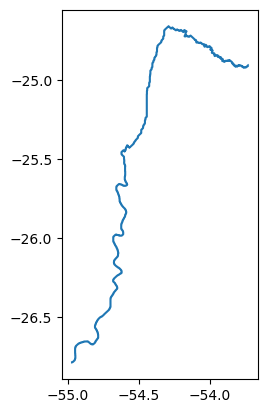

In [6]:
gdf.plot()